# Collaboration and Competition

---

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

We also print the current hyperparameters that are defined for the agent.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time

#from ddpg_agent import AgentArray
from ddpg_agent import Agent

print('torch current device',torch.cuda.current_device())
print('device name', torch.cuda.get_device_name(0))

Buffer SIZE 2000000, BATCH_SIZE 64, GAMMA 0.99, TAU 0.001 
 LR_ACTOR 0.0001, LR_CRITIC 0.0003, WEIGHT_DECAY 0.0001
torch current device 0
device name GeForce GTX 1080


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="/home/jupiter/Research/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python. In addition, we also print out the observation vectors of the state space and the action space.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

print("brain_name, brain", brain_name, brain)

brain_name, brain TennisBrain Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 24 variables per agent corresponding to the position and velocity of the ball and racket. Two continuous actions are available per agent, corresponding to movement toward (or away from) the net, and jumping. 

Also, we print an example state vector.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('Flattened version of the state is:', states.flatten())

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
Flattened version of the state is: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Instantiate the Agent

We instantiate the `Agent` class which combines two agents into a single by combining state space and action space. The agent also uses a single replay buffer.


In [5]:

seedv = random.randint(2, 10000)
agent = Agent(state_size=48, action_size=4, random_seed= 2)

### 4. DDPG for Tennis

The ddpg main function first loads the model if load_model parameter is True. Then the score_deque and score lists are initialized for keeping track of the scores. The ddpg runs until a determined number of episodes and max_t steps at each episode. If agent reaches its target, the algorithm terminates and prints the results. At each 100 episodes, the algorithm saves the current model.

The most important change over the single agent model is that we flatten state space and the action space and send it to the ddpg agent to step each time step. This means that the agent makes decisions based on both agents state space and actions.

Number of episodes to run 350000
loading the model...
Episode 1	Average Score: 0.10


/home/jupiter/.local/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 101	Average Score: 0.21
Episode 201	Average Score: 0.16
Episode 301	Average Score: 0.19
Episode 401	Average Score: 0.33

Environment solved in 448 episodes!	Average Score: 0.50
Runtime wall:  268.0117664337158


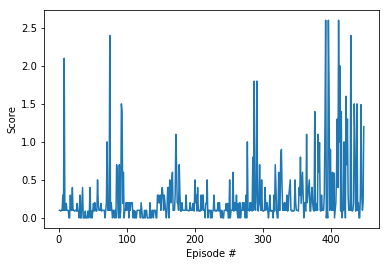

In [6]:
def ddpg(env_info, load_model = False, n_episodes=350000, max_t=5000, print_every=100):
    print('Number of episodes to run {}'.format(n_episodes))
    #load the model if it exists
    if load_model:
            print('loading the model...')
            fname_actor = 'checkpoint_actor_mult_tennis'+'.pth'
            fname_critic = 'checkpoint_critic_mult_tennis'+'.pth'
            state_dict = torch.load(fname_actor)
            agent.actor_local.load_state_dict(state_dict)
            agent.actor_target.load_state_dict(state_dict)
            state_dict = torch.load(fname_critic)
            agent.critic_local.load_state_dict(state_dict)
            agent.critic_target.load_state_dict(state_dict)

    
    #scores_deque = deque(maxlen=print_every)    #(Reacher single agent)
    scores_deque = deque(maxlen=print_every)
    scores = [] # will be scores for both 
    
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations          # get the current state
        states = states.flatten()
        #print("state shape 1", states.shape)
        #print('episode no', i_episode)
        score_p = [0,0] 

        for t in range(max_t):
            #print("state shape 2", states.shape)
            actions = agent.act(states) #ddpg agent action
            actions = actions.flatten()
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            next_states = next_states.flatten()
            rewards = env_info.rewards 
            dones = env_info.local_done                        # see if episode finished

            #if rewards[0] != 0:
            agent.step(states, actions, rewards, next_states, dones) ## two agents
            score_p[0] += rewards[0]
            score_p[1] += rewards[1]
            #if rewards[1] != 0:
            #agent.step(states, actions, rewards[1], next_states, dones) ## two agents
            #score_p[1] += rewards[1]

            states = next_states
            
            # roll over states to next time step
            if np.any(dones):                               # exit loop if episode finished
                break
        #print("scores", score_p[0], score_p[1])
        score = max(score_p[0], score_p[1])
        scores_deque.append(score)
        scores.append(score)
        
        scores_window = np.mean(scores_deque, dtype=np.float64)
        
        
        if i_episode % 100 == 1:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, scores_window))
            new_seed = random.seed()
            agent.seed = new_seed
            fname_actor = 'checkpoint_actor_tennis'+'.pth' 
            fname_critic = 'checkpoint_critic_tennis'+'.pth' 
            torch.save(agent.actor_local.state_dict(), fname_actor)
            torch.save(agent.critic_local.state_dict(), fname_critic)
        
        if scores_window >= 0.5 : # solving criteria
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, scores_window))
            fname_actor = 'checkpoint_actor_tennis'+'.pth' 
            fname_critic = 'checkpoint_critic_tennis'+'.pth' 
            torch.save(agent.actor_local.state_dict(), fname_actor)
            torch.save(agent.critic_local.state_dict(), fname_critic)
            break
            
    return scores

time_s = time.time()
scores = ddpg(env_info,load_model = True)
time_e = time.time() - time_s
print("Runtime wall: ", time_e)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [7]:
env.close()